In [3]:
import kete
import matplotlib.pyplot as plt
import numpy as np
import datetime
import warnings

import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

In [119]:
# Here we compute a State of the observer, this could also be constructed
# using spice kernels using kete.spice.state
sc_pos = kete.Vector([1.6207955157194764, -2.439532618937762, -0.3757900944990942],
                    kete.Frames.Ecliptic)
sc_vel = kete.Vector([0.00810409016131854, 0.005100499696532725, -0.001331612862551293],
                    kete.Frames.Ecliptic)

# now it is correctly formatted, load it
time_jd = 2460600.500800741

# Now there is a final state of the observer
sc_state = kete.State("WISE", time_jd, sc_pos, sc_vel)


# Build the corner position of the FOV in RA/DEC, and build those into vectors
# The WCS will raise a warning because the FITs files produced by WISE use an
# old format.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    frame_wcs = WCS(frame.header)
corners = []
dx, dy = frame_wcs.pixel_shape
for x, y in zip([0, 0, dx, dx], [0, dy, dy, 0]):
    coord = frame_wcs.pixel_to_world(x, y).icrs
    corners.append(kete.Vector.from_ra_dec(coord.ra.deg, coord.dec.deg))

# Build a generic FOV from the corners and the state of the observer
fov = kete.fov.RectangleFOV.from_corners(corners, sc_state)

In [123]:
# Load orbit data from the MPC
mpc_obs = kete.mpc.fetch_known_orbit_data()

# Convert that data to State objects.
mpc_states = kete.mpc.table_to_states(mpc_obs)

# It takes a while to propagate 1.5 million asteroids 14 years...
mpc_states = kete.propagate_n_body(mpc_states, time_jd)

Impact detected between Name("2008 TC3") <-> earth at time 2454746.6180044445 (2008-10-07T02:48:50.400+00:00)
Impact detected between Name("2014 AA") <-> earth at time 2456659.605350349 (2014-01-02T02:30:35.086+00:00)
Impact detected between Name("2015 FF415") <-> earth at time 2458266.658127209 (2018-05-28T03:46:33.006+00:00)
Impact detected between Name("2022 EB5") <-> earth at time 2459650.3937348765 (2022-03-11T21:25:49.509+00:00)
Impact detected between Name("2022 WJ1") <-> earth at time 2459902.8576111346 (2022-11-19T08:33:48.418+00:00)
Impact detected between Name("2023 CX1") <-> earth at time 2459988.630800741 (2023-02-13T03:07:11.999+00:00)
Impact detected between Name("2024 BX1") <-> earth at time 2460330.5266094888 (2024-01-21T00:37:09.875+00:00)
Impact detected between Name("2024 RW1") <-> earth at time 2460558.1967432345 (2024-09-04T16:42:09.431+00:00)


In [124]:
mpc_states

[State(desig="1", jd=2460600.500800741, pos=[1.6207955157194764, -2.439532618937762, -0.37579009449909406], vel=[0.00810409016131854, 0.005100499696532726, -0.0013316128625512932], frame=Ecliptic, center_id=10),
 State(desig="2", jd=2460600.500800741, pos=[-0.05160172836771215, -2.6480683299311307, 1.8391172327169905], vel=[0.008594781099366778, -0.0016427869901038206, 0.00039712176043301144], frame=Ecliptic, center_id=10),
 State(desig="3", jd=2460600.500800741, pos=[-2.8866712680050837, -1.253369708303143, 0.402022578809653], vel=[0.0021363662085050372, -0.008244488127591994, 0.0017848301765310836], frame=Ecliptic, center_id=10),
 State(desig="4", jd=2460600.500800741, pos=[-2.233342977204779, 0.6875340747451829, 0.25153327167359274], vel=[-0.0022551691965955025, -0.011001180852792827, 0.0006012810612323503], frame=Ecliptic, center_id=10),
 State(desig="5", jd=2460600.500800741, pos=[-2.156804817494455, -0.5937792868692016, 0.16962536171684545], vel=[0.001646964785418522, -0.01206651

In [125]:
visible_obj = kete.fov_state_check(mpc_states, [fov], include_asteroids=True)[0]

In [126]:
visible_obj

SimultaneousStates(states=<1 States>, fov=GenericRectangle(pointing=Vector([-0.169417170795, 0.707874671215, 0.685719528737], Ecliptic), observer=State(desig="WISE", jd=2460600.500800741, pos=[1.6207955157194764, -2.439532618937762, -0.3757900944990942], vel=[0.00810409016131854, 0.005100499696532725, -0.001331612862551293], frame=Ecliptic, center_id=10), lon_width=0.5234188024901759, lat_width=0.524259375835907))

## Test 2

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


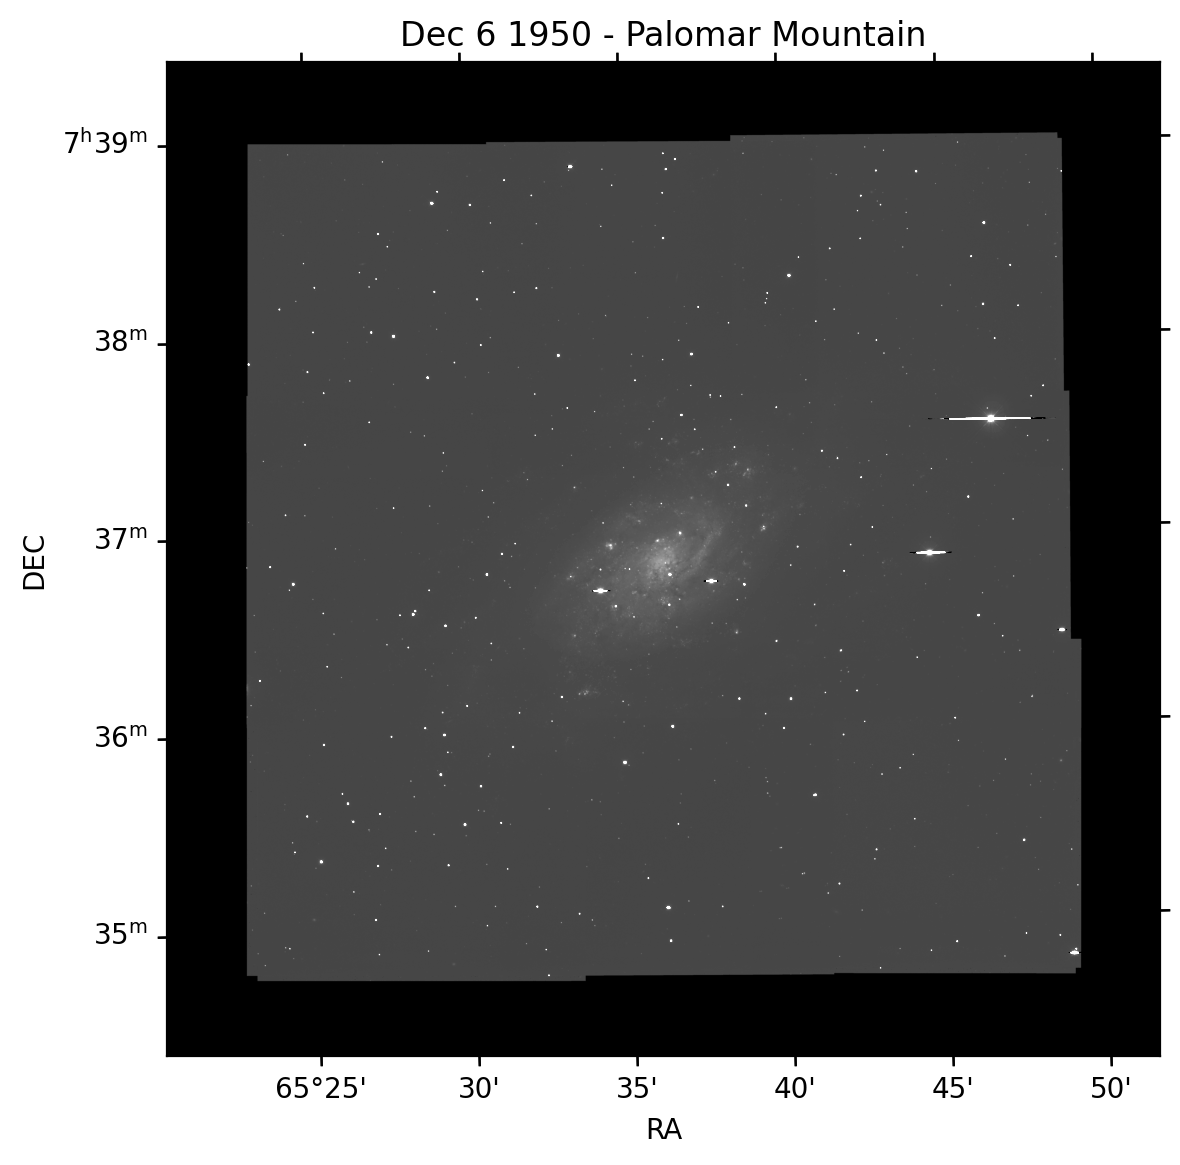

In [4]:
# load the fits file and associated WCS
frame = fits.open("ngc2403_V_dr4.fits")[0]
wcs = WCS(frame.header)

# Time of observation, approximately 3 am local time
# Taken from table A1 of the paper cited above.
jd = kete.Time(2433622.977, scaling='utc').jd

earth = kete.spice.get_state("Earth", jd)
fov = kete.fov.RectangleFOV.from_wcs(wcs, earth)

# Plot the frame
kete.irsa.plot_fits_image(frame)
plt.title("Dec 6 1950 - Palomar Mountain")
plt.tight_layout()

In [5]:
table = kete.mpc.fetch_known_orbit_data()
table = table[[str(t).isdigit() for t in table['desig']]]
table = table[table['ecc'] < 0.5]
table = table[table['peri_dist'] < 4]
states = kete.mpc.table_to_states(table)

# It takes a while to propagate 1.5 million asteroids 14 years...
states = kete.propagate_n_body(states, jd)

In [6]:
vis = kete.fov_state_check(states, [fov], include_asteroids=True)[0]

Text(0.5, 1.0, 'Dec 6 1950 - Annotated')

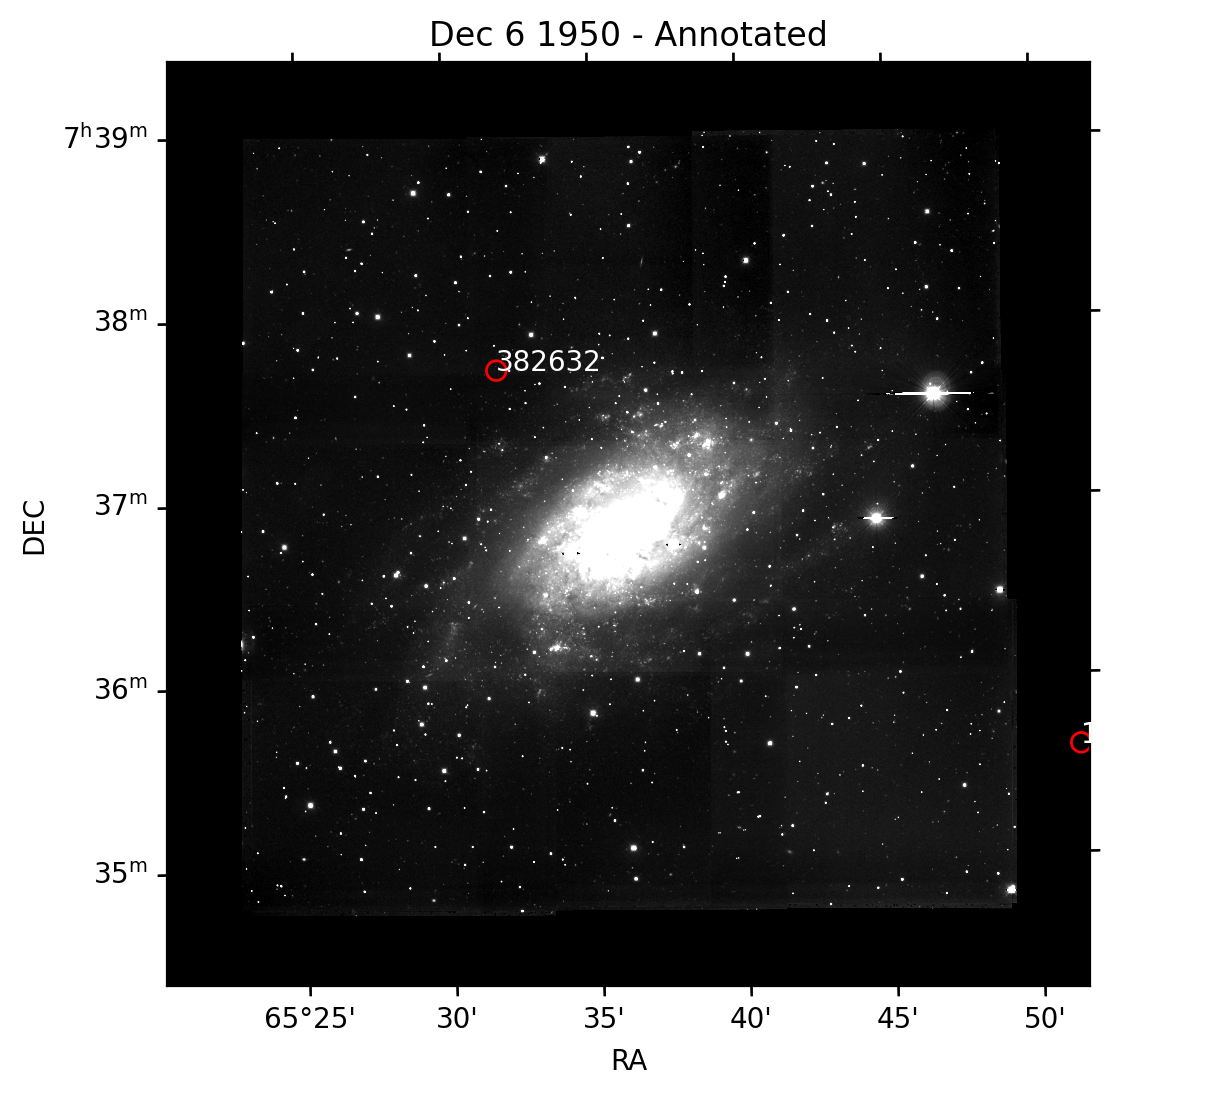

In [7]:
wcs = kete.irsa.plot_fits_image(frame, percentiles=(40, 99))
for idx in range(len(vis)):
    vec = vis.obs_vecs[idx]
    kete.irsa.annotate_plot(wcs, vec, style='o', px_gap=10, text=vis[idx].desig)

plt.title("Dec 6 1950 - Annotated")